# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [159]:
# Data manipulation
import cufflinks as cf
import altair as alt
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearnex import patch_sklearn

# Additional packages
from sklearn import preprocessing
import lazypredict

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
alt.renderers.enable('notebook')
alt.renderers.enable('html')

cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Data Wrangling

## Basic Data Manipulation

In [160]:
# Reading in data
demographics = pd.read_csv("dataScienceTask/T_demo.csv")
dbp = pd.read_csv("dataScienceTask/T_DBP.csv")
sbp = pd.read_csv("dataScienceTask/T_SBP.csv")
creatinine = pd.read_csv("dataScienceTask/T_creatinine.csv")
glucose = pd.read_csv("dataScienceTask/T_glucose.csv")
meds = pd.read_csv("dataScienceTask/T_meds.csv")
hgb = pd.read_csv("dataScienceTask/T_HGB.csv")
ldl = pd.read_csv("dataScienceTask/T_ldl.csv")
stage = pd.read_csv("dataScienceTask/T_stage.csv")

In [161]:
# Aggregating data into 1 dataframe
df = pd.DataFrame()

for i in demographics['id']:
    temp = dbp.loc[dbp['id'] == i][['time', 'value']].merge(sbp.loc[sbp['id'] == i][[
        'value', 'time']], left_on='time', right_on='time', suffixes=('_dbp', '_sbp'), how='outer')
    temp = temp.merge(creatinine.loc[creatinine['id'] == i][['time', 'value']], left_on='time',
                      right_on='time', how='outer').rename(columns={"value": "value_creatinine"})
    temp = temp.merge(glucose.loc[glucose['id'] == i][['time', 'value']], left_on='time',
                      right_on='time', how='outer').rename(columns={"value": "value_glucose"})
    temp = temp.merge(hgb.loc[hgb['id'] == i][['time', 'value']], left_on='time',
                      right_on='time', how='outer').rename(columns={"value": "value_hgb"})
    temp = temp.merge(ldl.loc[ldl['id'] == i][['time', 'value']], left_on='time',
                      right_on='time', how='outer').rename(columns={"value": "value_ldl"})
    temp = temp.sort_values(by=['time'])
    temp['id'] = i
    df = df.append(temp)

df = df.merge(demographics[['id', 'gender', 'race']],
              left_on='id', right_on='id')

df

,time,value_dbp,value_sbp,value_creatinine,value_glucose,value_hgb,value_ldl,id,gender,race
0,0,95.32,134.11,1.29,6.24,13.51,161.49,0,Male,Unknown
1,98,83.98,133.75,NaN,NaN,NaN,NaN,0,Male,Unknown
2,107,NaN,NaN,1.15,7.20,13.39,111.39,0,Male,Unknown
3,279,65.97,125.08,NaN,NaN,NaN,NaN,0,Male,Unknown
4,286,NaN,NaN,1.44,7.01,12.84,NaN,0,Male,Unknown
...,...,...,...,...,...,...,...,...,...,...
4756,621,72.52,113.38,NaN,NaN,NaN,NaN,299,Male,Asian
4757,652,NaN,NaN,0.82,NaN,NaN,NaN,299,Male,Asian
4758,659,NaN,NaN,NaN,6.20,14.43,79.02,299,Male,Asian
4759,1069,NaN,NaN,NaN,NaN,14.90,NaN,299,Male,Asian


In [162]:
# Brief look at the data
df.describe()

,time,value_dbp,value_sbp,value_creatinine,value_glucose,value_hgb,value_ldl,id
count,4761.00000,1821.000000,1809.000000,1439.000000,1556.000000,2025.000000,1261.000000,4761.000000
mean,462.41924,79.518583,134.155368,1.328999,6.694833,13.825185,87.558795,148.060912
std,334.49964,10.178676,14.765817,0.357971,1.599058,1.644946,28.156104,88.343602
min,0.00000,44.950000,91.990000,0.240000,2.890000,8.820000,26.100000,0.000000
25%,196.00000,72.830000,124.630000,1.080000,5.620000,12.670000,67.290000,70.000000
50%,414.00000,79.050000,133.440000,1.290000,6.360000,13.920000,83.960000,147.000000
75%,640.00000,86.170000,143.160000,1.530000,7.440000,14.980000,105.140000,227.000000
max,1429.00000,112.930000,211.090000,3.020000,16.610000,19.000000,198.590000,299.000000


In [163]:
# merging demographics and disease stage progression
demo_stage = demographics.merge(
    stage, left_on='id', right_on='id', how='outer')

In [164]:
# the medication proved to be most difficult to sort because of the number of medications, variations in dosage, and dates
meds.describe()
meds['drug'].unique()

array(['atorvastatin', 'losartan', 'metformin', 'rosuvastatin',
       'pravastatin', 'carvedilol', 'valsartan', 'metoprolol',
       'simvastatin', 'bisoprolol', 'atenolol', 'lovastatin',
       'olmesartan', 'irbesartan', 'canagliflozin', 'dapagliflozin',
       'telmisartan', 'labetalol', 'nebivolol', 'pitavastatin',
       'propranolol'], dtype=object)

Looking at the different medications there are several major groups of medication. Statins (atorvastatin, rosuvastatin, pravastatin, simvastatin, lovastatin, pitavastatin), angiotensin receptor blocker (losartan, valsartan, olmesartan, irbesartan, telmisartan), biguanide antihyperglycemic agent (metformin), beta blocker (carvedilol, metoprolol, bisoprolol, atenolol, labeltalol, nebivolol, propranolol) and sodium-glucose cotransporter-2 (SGLT2) inhibitor (canagliflozin). Statins reduce cholestrol, angiotensin receptor blockers and beta blockers reduce blood pressure, and biguanide antihyperglycemic agent and sodium-glucose cotransporter-2 (SGLT2) inhibitor reduce blood glucose levels. Choice was made to just add the number of medications for each person as a simple initial feature engineering move. The number of medications would be a strong correlation to the number of risk factors the patient has for CKD. 

In [165]:
aggregate = pd.DataFrame()

In [166]:
for i in demographics['id']:
    dbp = df[(df['id'] == i) & (df['value_dbp'] > 85)
             ]['value_dbp'].count() / df[(df['id'] == i)]['value_dbp'].count()
    sbp = df[(df['id'] == i) & (df['value_sbp'] > 129)
             ]['value_sbp'].count() / df[(df['id'] == i)]['value_sbp'].count()
    hgb = df[(df['id'] == i) & (df['value_hgb'] < 9)
             ]['value_hgb'].count() / df[(df['id'] == i)]['value_hgb'].count()
    ldl = df[(df['id'] == i) & (df['value_ldl'] > 160)
             ]['value_ldl'].count() / df[(df['id'] == i)]['value_ldl'].count()
    glucose = df[(df['id'] == i) & ((df['value_glucose'] > 6.9) | (df['value_glucose'] < 3.8))
                 ]['value_glucose'].count() / df[(df['id'] == i)]['value_glucose'].count()
    medications = len(meds[meds['id'] == i]['drug'].unique())
    if demographics[demographics['id'] == i]['gender'].item() == 'Male':
        creatinine = df[(df['id'] == i) & (df['value_creatinine'] > 1.2)]['value_creatinine'].count(
        ) / df[(df['id'] == i)]['value_creatinine'].count()
    else:
        creatinine = df[(df['id'] == i) & (df['value_creatinine'] > 1.0)]['value_creatinine'].count(
        ) / df[(df['id'] == i)]['value_creatinine'].count()

    temp = pd.DataFrame({'id': i, 'gender': demographics[demographics['id'] == i]['gender'],
                        'dbp': dbp, 'sbp': sbp, 'hgb': hgb, 'ldl': ldl, 'glucose': glucose, 'creatinine': creatinine, 'medications': medications})
    aggregate = aggregate.append(temp)

aggregate = aggregate.merge(
    demo_stage[['race', 'age', 'Stage_Progress', 'id']], left_on='id', right_on='id', how='inner')

In [167]:
# looking at some calculated factors in ckd
aggregate.describe()
aggregate

,id,gender,dbp,sbp,hgb,ldl,glucose,creatinine,medications,race,age,Stage_Progress
0,0,Male,0.375000,0.875000,0.0,0.333333,0.333333,0.666667,3,Unknown,70,True
1,1,Female,0.285714,1.000000,0.0,0.000000,1.000000,1.000000,1,White,71,False
2,2,Female,0.750000,1.000000,0.0,0.000000,0.666667,1.000000,1,White,57,True
3,3,Male,0.000000,0.714286,0.0,0.000000,0.333333,0.200000,1,White,74,False
4,4,Female,0.857143,0.857143,0.0,0.000000,1.000000,0.833333,3,White,50,True
...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,Female,0.250000,0.875000,0.0,0.000000,0.142857,1.000000,0,White,79,True
296,296,Female,0.714286,0.571429,0.0,0.000000,1.000000,1.000000,2,White,66,False
297,297,Male,0.000000,0.375000,0.0,0.000000,1.000000,0.666667,5,Unknown,80,True
298,298,Female,0.000000,0.500000,0.0,0.000000,0.000000,0.600000,2,Asian,72,False


## Data Manipulation for Machine Learning

In [168]:
# Dealing with categorical data
# Checking gender
data_array = np.array(aggregate)
data_array

array([[0, 'Male', 0.375, ..., 'Unknown', 70, True],
       [1, 'Female', 0.2857142857142857, ..., 'White', 71, False],
       [2, 'Female', 0.75, ..., 'White', 57, True],
       ...,
       [297, 'Male', 0.0, ..., 'Unknown', 80, True],
       [298, 'Female', 0.0, ..., 'Asian', 72, False],
       [299, 'Male', 0.14285714285714285, ..., 'Asian', 84, False]],
      dtype=object)

In [169]:
# Changing gender from categorical to ordinal
enc = preprocessing.OrdinalEncoder()
enc.fit(data_array[:, 1].reshape(-1, 1))
data_array[:, 1] = enc.transform(
    data_array[:, 1].reshape(-1, 1)).reshape(1, -1)
data_array
enc.get_params()

{'categories': 'auto',
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'unknown_value': None}

In [170]:
# Changing stage progress from categorical to ordinal
enc.fit(data_array[:, -1].reshape(-1, 1))
data_array[:, -
           1] = enc.transform(data_array[:, -1].reshape(-1, 1)).reshape(1, -1)
data_array
enc.get_params()

{'categories': 'auto',
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'unknown_value': None}

In [171]:
# Do one hot encoding for race (categorical data)
# Change "Unknown" into np.nan
data_array[:, -3] = np.where(data_array[:, -3] ==
                             'Unknown', np.nan, data_array[:, -3])
# Do one hot encoding for race
enc2 = preprocessing.OneHotEncoder()
enc2.fit(data_array[:, -3].reshape(-1, 1))
race = enc2.transform(data_array[:, -3].reshape(-1, 1)).toarray()
enc2.get_feature_names()

array(['x0_Asian', 'x0_Black', 'x0_Hispanic', 'x0_White', 'x0_nan'],
      dtype=object)

In [172]:
# Removing original race independent variable and replacing it with one hot encoding array
data_array_final = np.delete(data_array, -3, 1)
data_array_final = np.insert(data_array_final, [-2], race, 1)
# Removing ID from array
data_array_final = data_array_final[:, 1:]

In [173]:
data_array_final

array([[1.0, 0.375, 0.875, ..., 1.0, 70, 1.0],
       [0.0, 0.2857142857142857, 1.0, ..., 0.0, 71, 0.0],
       [0.0, 0.75, 1.0, ..., 0.0, 57, 1.0],
       ...,
       [1.0, 0.0, 0.375, ..., 1.0, 80, 1.0],
       [0.0, 0.0, 0.5, ..., 0.0, 72, 0.0],
       [1.0, 0.14285714285714285, 0.2857142857142857, ..., 0.0, 84, 0.0]],
      dtype=object)

In [174]:
# get 'column names for array'
col_names = ['gender',
             'dbp',
             'sbp',
             'hgb',
             'ldl',
             'glucose',
             'creatinine',
             'medications',
             'x0_Asian', 
             'x0_Black', 
             'x0_Hispanic', 
             'x0_White', 
             'x0_nan',
             'age']

# Basic Data Visualization of the Demographics
Looking at basic demographics of the patients

In [175]:
alt.Chart(demo_stage).mark_bar().encode(
    alt.X("age:Q", bin=True),
    alt.Y('count()', title='Number of Patients'),
    column='race',
    color='Stage_Progress'
).properties(
    width=150,
    height=120
)

alt.Chart(...)

In [176]:
alt.Chart(demo_stage).mark_bar().encode(
    alt.X("age:Q", bin=True),
    alt.Y("count()", title='Number of Patients'),
    column='gender',
    color='Stage_Progress'
).properties(
    width=300,
    height=150
)

alt.Chart(...)

Looking at the demographics data, there are more white patients than of the other races. In terms of gender, there are more more female patients across all age bins, but the difference is not as large as compared to the race differences. 

In [177]:
alt.Chart(demo_stage, title='Percentage of CKD patients').mark_bar().encode(
    alt.X("age:Q", bin=True),
    alt.Y('count()', stack="normalize", axis=alt.Axis(
        format=".0%"), title='Precentage of Patients'),
    color='Stage_Progress'
).properties(
    width=300,
    height=150
)

alt.Chart(...)

Just looking at outcomes (Stage_Progress), there are more patients who do not have chronic kidney disease (CKD) compared to patients who have CKD (inbalanced dataset). 

In [178]:
positive = alt.Chart(demo_stage.loc[demo_stage['Stage_Progress'] == True], title="CKD Positive").mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).encode(
    x=alt.X('age:Q', bin=True),
    y=alt.Y('count():Q', scale=alt.Scale(
        domain=(0, 46)), title='Number of Patients'),
    color='race:N'
)
negative = alt.Chart(demo_stage.loc[demo_stage['Stage_Progress'] == 0], title="CKD Negative").mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).encode(
    x=alt.X('age:Q', bin=True),
    y=alt.Y('count():Q', scale=alt.Scale(
        domain=(0, 46)), title='Number of Patients'),
    color='race:N'
)

positive | negative

alt.HConcatChart(...)

In [179]:
male = alt.Chart(demo_stage.loc[demo_stage['gender'] == 'Male'], title="Male").mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).encode(
    x=alt.X('age:Q', bin=True),
    y=alt.Y('count():Q', scale=alt.Scale(
        domain=(0, 46)), title='Number of Patients'),
    color='race:N'
)

female = alt.Chart(demo_stage.loc[demo_stage['gender'] == 'Female'], title="Female").mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).encode(
    x=alt.X('age:Q', bin=True),
    y=alt.Y('count():Q', scale=alt.Scale(
        domain=(0, 46)), title='Number of Patients'),
    color='race:N'
)

male | female

alt.HConcatChart(...)

# Splitting and scaling data

## Splitting data into training and testing set

In [180]:
# Splitting data into 2 sets, 25% of dataset will be used for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_array_final[:, :-1], data_array_final[:, -1], random_state=42)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

## Scaling data

In [181]:
# Scaling train data
# Using RobustScaler in case of outliers
from sklearn.preprocessing import RobustScaler
num_rows, num_cols = X_train.shape
i = 0
X_train_scaled = np.empty(X_train.shape)
X_test_scaled = np.empty(X_test.shape)
# Using train data fit to scale test data too (prevent data leakage)
while i < num_cols:
    transformer = RobustScaler().fit(X_train[:, i].reshape(-1, 1))
    X_train_scaled[:, i] = transformer.transform(
        X_train[:, i].reshape(-1, 1)).reshape(1, -1)
    X_test_scaled[:, i] = transformer.transform(
        X_test[:, i].reshape(-1, 1)).reshape(1, -1)
    i += 1

# Analysis/Modeling

## Random Forest Classifier

In [182]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

print(models)

ImportError: cannot import name '_raise_dep_warning_if_not_pytest' from 'sklearn.utils.deprecation' (/Users/blaubear/opt/anaconda3/envs/ckd/lib/python3.7/site-packages/sklearn/utils/deprecation.py)

In [183]:
# load library
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train_scaled, y_train)

# predict
rfc_predict = rfc.predict(X_test_scaled)  # check performance
print('ROCAUC score:', roc_auc_score(y_test, rfc_predict))
print('Accuracy score:', accuracy_score(y_test, rfc_predict))
print('F1 score:', f1_score(y_test, rfc_predict))  # load library

print("RF train accuracy: %0.3f" % rfc.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rfc.score(X_test, y_test))

ROCAUC score: 0.6593137254901962
Accuracy score: 0.7466666666666667
F1 score: 0.5128205128205129
RF train accuracy: 0.658
RF test accuracy: 0.667


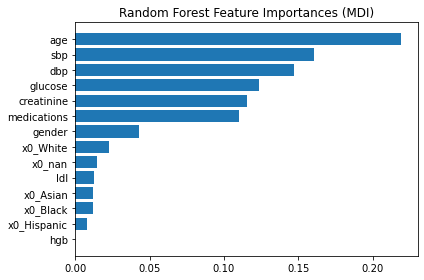

In [184]:
from sklearn.inspection import permutation_importance

# ohe = (rfc.named_steps['preprocess']
#         .named_transformers_['cat'])
#feature_names = ohe.get_feature_names(input_features=categorical_columns)
#feature_names = np.r_[col_names]
col_names = np.array(col_names)
tree_feature_importances = (
    rfc.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(col_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(col_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")

fig.tight_layout()
plt.show()

## AdaBoosted Decision Trees

In [185]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train_scaled, y_train)
bdt_discrete.fit(X_train_scaled, y_train)

# predict
bdt_real_predict = bdt_real.predict(X_test_scaled)  # check performance
print('SAMME.R ROCAUC score:', roc_auc_score(y_test, bdt_real_predict))
print('SAMME.R Accuracy score:', accuracy_score(y_test, bdt_real_predict))
print('SAMME.R F1 score:', f1_score(y_test, bdt_real_predict))  # load library

print("SAMME.R train accuracy: %0.3f" % bdt_real.score(X_train, y_train))
print("SAMME.R test accuracy: %0.3f" % bdt_real.score(X_test, y_test))

SAMME.R ROCAUC score: 0.704656862745098
SAMME.R Accuracy score: 0.7333333333333333
SAMME.R F1 score: 0.6
SAMME.R train accuracy: 0.480
SAMME.R test accuracy: 0.480


In [186]:
bdt_discrete_predict = bdt_discrete.predict(X_test_scaled)  # check performance
print('SAMME ROCAUC score:', roc_auc_score(y_test, bdt_discrete_predict))
print('SAMME Accuracy score:', accuracy_score(y_test, bdt_discrete_predict))
print('SAMME F1 score:', f1_score(y_test, bdt_discrete_predict))  # load library

print("SAMME train accuracy: %0.3f" % bdt_discrete.score(X_train, y_train))
print("SAMME test accuracy: %0.3f" % bdt_discrete.score(X_test, y_test))

SAMME ROCAUC score: 0.6335784313725489
SAMME Accuracy score: 0.6666666666666666
SAMME F1 score: 0.5098039215686274
SAMME train accuracy: 0.591
SAMME test accuracy: 0.613


In [187]:
real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test_scaled), bdt_discrete.staged_predict(X_test_scaled)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

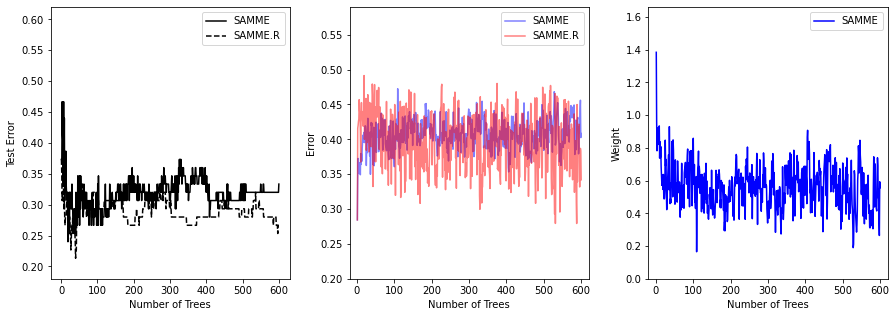

In [188]:
# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1),
         discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors,
         "b", label='SAMME', alpha=.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors,
         "r", label='SAMME.R', alpha=.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((.2,
         max(real_estimator_errors.max(),
             discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights,
         "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

In [189]:
rfc_real = AdaBoostClassifier(
    RandomForestClassifier(max_depth=2),
    n_estimators=100,
    learning_rate=1)

rfc_discrete = AdaBoostClassifier(
    RandomForestClassifier(max_depth=2),
    n_estimators=100,
    learning_rate=1.5,
    algorithm="SAMME")

rfc_real.fit(X_train_scaled, y_train)
rfc_discrete.fit(X_train_scaled, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=RandomForestClassifier(max_depth=2),
                   learning_rate=1.5, n_estimators=100)

In [191]:
rfc_discrete_predict = rfc_discrete.predict(X_test_scaled)  # check performance
print('SAMME ROCAUC score:', roc_auc_score(y_test, rfc_discrete_predict))
print('SAMME Accuracy score:', accuracy_score(y_test, rfc_discrete_predict))
print('SAMME F1 score:', f1_score(y_test, rfc_discrete_predict))  # load library

print("SAMME train accuracy: %0.3f" % rfc_discrete.score(X_train, y_train))
print("SAMME test accuracy: %0.3f" % rfc_discrete.score(X_test, y_test))

SAMME ROCAUC score: 0.6470588235294117
SAMME Accuracy score: 0.64
SAMME F1 score: 0.5423728813559322
SAMME train accuracy: 0.644
SAMME test accuracy: 0.680


In [190]:
# predict
rfc_real_predict = rfc_real.predict(X_test_scaled)  # check performance
print('SAMME.R ROCAUC score:', roc_auc_score(y_test, rfc_real_predict))
print('SAMME.R Accuracy score:', accuracy_score(y_test, rfc_real_predict))
print('SAMME.R F1 score:', f1_score(y_test, rfc_real_predict))  # load library

print("SAMME.R train accuracy: %0.3f" % rfc_real.score(X_train, y_train))
print("SAMME.R test accuracy: %0.3f" % rfc_real.score(X_test, y_test))

SAMME.R ROCAUC score: 0.6544117647058825
SAMME.R Accuracy score: 0.68
SAMME.R F1 score: 0.5384615384615384
SAMME.R train accuracy: 0.640
SAMME.R test accuracy: 0.720


# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here